<a href="https://colab.research.google.com/github/felipevarelacarvalho/SeedDetection/blob/main/Seed_Detection_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset

In [2]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import argparse
import shutil

from lxml import etree
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torchvision
import seaborn as sns
from PIL import Image, ImageDraw

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_directory = "/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/images/Images_Bulk_labelling_mini/MiniSET5"
annotations_directory = "/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/annotations.xml"

# Pre-Processing

## Create data frame of annotations

In [5]:
#XML parser 
#One XML contains all the images annotation. 
#This parser creates a list of dictionaries containing the image name with the coordinates of the bounding box of the seed. 
root = etree.parse(annotations_directory).getroot()
anno = []
image_info = {}

for image in root.iter('image'):
  #print(image.attrib)
  image_name = image.attrib['name']
  image_width = image.attrib['width']
  image_height = image.attrib['height']
  #print(image_name)
  #image_info = {'name':image_name}

  for box in image.findall('box'):
    if box.attrib['label'] == 'Seed':
      #print(box.items())
      
      for key, value in box.items():
        image_info['name'] = image_name
        image_info['width'] = image_width
        image_info['height'] = image_height
        image_info[key] = value
        #print(image_info.keybs())
      #print(image_info)
      
      #print(anno)
      anno.append(image_info)
      image_info = {} 

In [6]:
#Creates a dataframe out of the list of dictionaries
width = []
height = []
image_name = []
labels =[]
xtl = []
ytl = []
xbr = []
ybr = []

for item in anno:
  #print(item.keys())
  image_name.append(item['name'])
  width.append(item['width'])
  height.append(item['height'])
  labels.append(0)
  xtl.append(float(item['xtl']))
  ytl.append(float(item['ytl']))
  xbr.append(float(item['xbr']))
  ybr.append(float(item['ybr']))

df = pd.DataFrame(list(zip(image_name, width, height, labels, xtl, ytl,xbr,ybr)),
               columns =['Name','width', 'height', 'Label', 'xmin', 'ymin','xmax','ymax'])


In [95]:
df.head(3)

,Name,width,height,Label,xmin,ymin,xmax,ymax
0,image_sensorid_4_frame_312300_ts_1620159456.28...,1086,1448,0,467.29,743.27,522.79,810.54
1,image_sensorid_4_frame_312292_ts_1620159455.75...,1086,1448,0,460.57,153.19,513.96,201.17
2,image_sensorid_4_frame_312292_ts_1620159455.75...,1086,1448,0,426.93,741.59,479.06,812.22


In [96]:
df_train = df

## Sample Image with Bounding Box

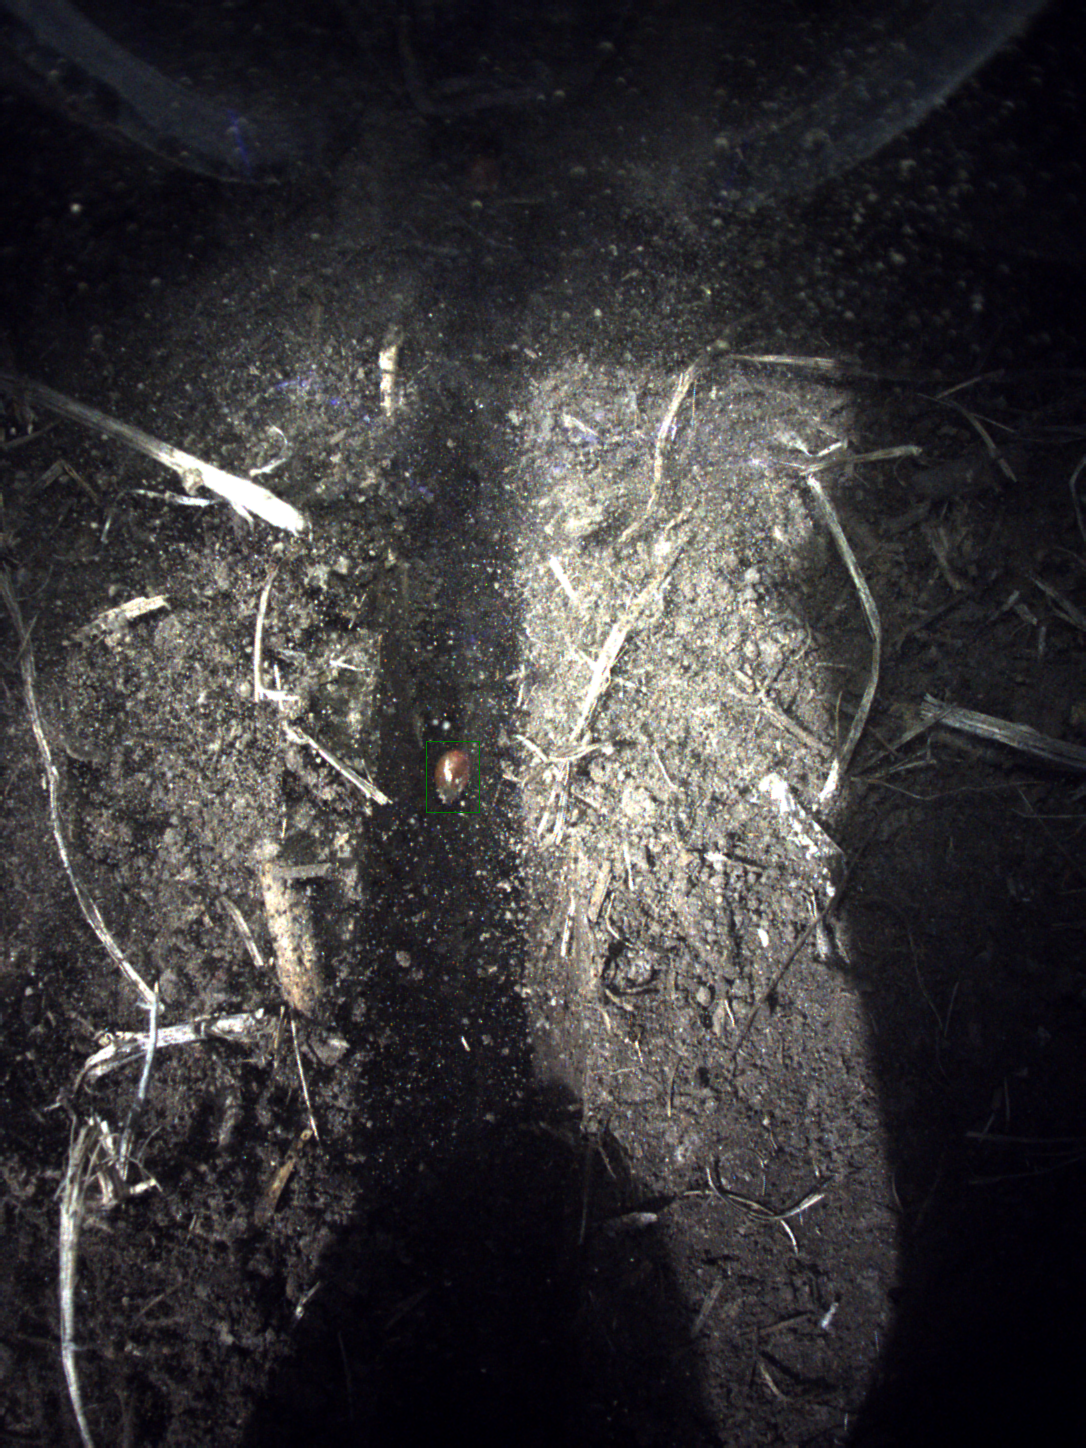

In [18]:
sample_image = Image.open(image_directory + '/' + anno[2]['name'])
box_coor = [float(anno[2]['xtl']), float(anno[2]['ytl']), float(anno[2]['xbr']), float(anno[2]['ybr'])]
img_bbox = ImageDraw.Draw(sample_image)
img_bbox.rectangle(box_coor, outline="green") 

sample_image

## Image Mask

In [19]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

## Sample Image with Mask

In [20]:
# im = cv2.imread(str(df_train.values[58][8]))
im = cv2.imread( image_directory + '/' + str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(bb)
print(im.shape)

[369.92 465.61 418.69 509.33]
(1448, 1086, 3)


In [21]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([369., 465., 417., 508.], dtype=float32)

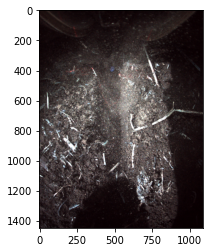

In [22]:
plt.imshow(im)

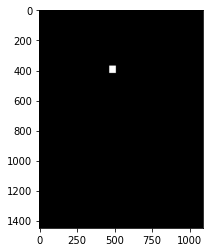

In [23]:
plt.imshow(Y, cmap='gray')

## Resizng Images and Bounding Boxes

In [33]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [34]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, int(0.75*sz)))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, int(0.75*sz)))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [37]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(Path(image_directory + '/' + row['Name']), train_path_resized, create_bb_array(row.values), 600)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

## Generating Dataset

In [9]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [58]:
from google.colab.patches import cv2_imshow

train_dataset = df_train
train_df = train_dataset
image_ids =train_df['Name']

image_id = image_ids[0]
bboxes = train_df[train_df['Name'] == image_id]
image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/images/Images_Bulk_labelling_mini/MiniSET5/{image_id}', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0 # Apply normalization

boxes = bboxes[['xmin', 'ymin', 'xmax', 'ymax']].values
area = (boxes[:,3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
print(boxes, area)

boxes = torch.as_tensor(boxes, dtype=torch.float32)
area = torch.as_tensor(area, dtype = torch.float32)
print(boxes, area)

labels = torch.ones((bboxes.shape[0],), dtype = torch.int64)
iscrowd = torch.zeros((bboxes.shape[0],), dtype = torch.int64)
print(labels, iscrowd)

target = {}
target['boxes'] = boxes
target['labels'] = labels
target['image_id'] = torch.tensor([0])
target['area'] = area
target['iscrowd'] = iscrowd

image = torchvision.transforms.ToTensor()(image)

print(target)

image_ids.shape[0]

[[467.29 743.27 522.79 810.54]] [3733.485]
tensor([[467.2900, 743.2700, 522.7900, 810.5400]]) tensor([3733.4851])
tensor([1]) tensor([0])
{'boxes': tensor([[467.2900, 743.2700, 522.7900, 810.5400]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([3733.4851]), 'iscrowd': tensor([0])}


277

In [92]:
class TrainDataset(Dataset):
  def __init__(self, annotation_dataframe):
      self.train_df = annotation_dataframe
      self.image_ids = self.train_df['Name']

  def __getitem__(self, index):
      image_id = self.image_ids[index]
      bboxes = self.train_df[self.train_df['Name'] == image_id]

      image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/images/Images_Bulk_labelling_mini/MiniSET5/{image_id}', cv2.IMREAD_COLOR)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0 # Apply normalization

      boxes = bboxes[['xmin', 'ymin', 'xmax', 'ymax']].values
      area = (boxes[:,3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      area = torch.as_tensor(area, dtype = torch.float32)

      labels = torch.ones((bboxes.shape[0],), dtype = torch.int64)
      iscrowd = torch.zeros((bboxes.shape[0],), dtype = torch.int64)

      target = {}
      target['boxes'] = boxes
      target['labels'] = labels
      target['image_id'] = torch.tensor([index])
      target['area'] = area
      target['iscrowd'] = iscrowd

      image = torchvision.transforms.ToTensor()(image)
      return image, target

  def __len__(self) -> int:
      return self.image_ids.shape[0]

  

In [98]:
# Initialize Dataset
train_dataset = TrainDataset(df_train)

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [99]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[467 743 522 810]


TypeError: ignored

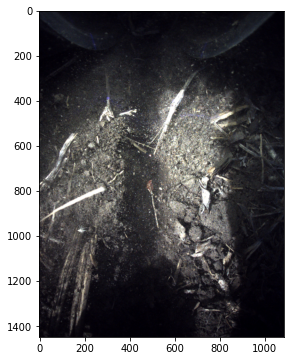

In [129]:
import matplotlib.patches as patches
images, targets = next(iter((train_data_loader)))
images = list(image.to(device) for image in images)
targets = [{k : v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.imshow(img)

print(box)
rect = patches.Rectangle(img, (box[0], box[1]), (box[2], box[3]), (220, 0 ,0 ),  3)
ax.set_axis_off()
print(img.shape)
